In [ ]:
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import MimiModel, AutoFeatureExtractor
from datasets import load_dataset, Audio
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :].transpose(0, 1)
        return self.dropout(x)


class AttentionPooling(nn.Module):
    def __init__(self, d_model, num_heads=4):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        self.query = nn.Parameter(torch.randn(1, 1, d_model))
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=num_heads,
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, level_outputs):
        batch_size = level_outputs[0].size(0)
        stacked = torch.stack(level_outputs, dim=1)
        query = self.query.expand(batch_size, -1, -1)
        attn_output, attn_weights = self.multihead_attn(
            query, stacked, stacked
        )
        attn_output = attn_output.squeeze(1)
        output = self.layer_norm(attn_output)
        return output


class MultiRVQGenderClassifier(nn.Module):
    def __init__(
        self,
        num_rvq_levels=4,
        codebook_size=2048,
        d_model=256,
        nhead=8,
        num_layers=2,
        dim_feedforward=512,
        dropout=0.1,
        num_classes=2,
        pooling_heads=4
    ):
        super().__init__()
        self.num_rvq_levels = num_rvq_levels
        self.d_model = d_model
        self.codebook_embeddings = nn.ModuleList([
            nn.Embedding(codebook_size, d_model)
            for _ in range(num_rvq_levels)
        ])
        self.positional_encodings = nn.ModuleList([
            PositionalEncoding(d_model, dropout, max_len=5000)
            for _ in range(num_rvq_levels)
        ])
        self.transformer_encoders = nn.ModuleList()
        for _ in range(num_rvq_levels):
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True
            )
            transformer_encoder = nn.TransformerEncoder(
                encoder_layer,
                num_layers=num_layers
            )
            self.transformer_encoders.append(transformer_encoder)
        self.temporal_pooling = nn.AdaptiveAvgPool1d(1)
        self.attention_pooling = AttentionPooling(d_model, num_heads=pooling_heads)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )

    def forward(self, audio_codes_list, padding_mask=None):
        level_outputs = []
        for level_idx in range(self.num_rvq_levels):
            audio_codes = audio_codes_list[level_idx]
            x = self.codebook_embeddings[level_idx](audio_codes)
            x = self.positional_encodings[level_idx](x)
            x = self.transformer_encoders[level_idx](x, src_key_padding_mask=padding_mask)
            x = x.transpose(1, 2)
            x = self.temporal_pooling(x).squeeze(-1)
            level_outputs.append(x)
        combined = self.attention_pooling(level_outputs)
        logits = self.classifier(combined)
        return logits


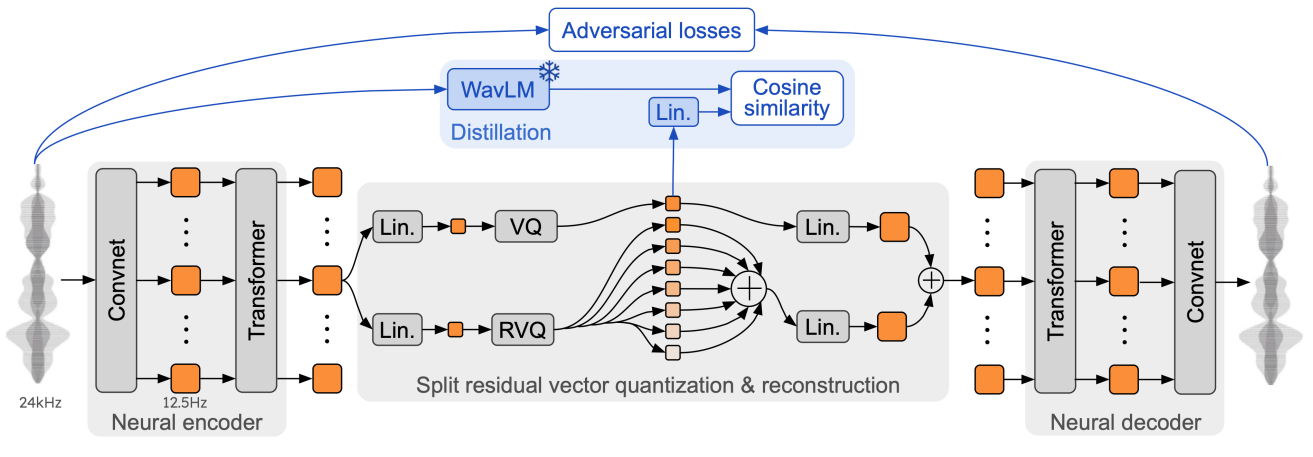

In [ ]:
print("Loading Mimi model...")
mimi_model = MimiModel.from_pretrained("kyutai/mimi")
feature_extractor = AutoFeatureExtractor.from_pretrained("kyutai/mimi")
mimi_model.eval()
mimi_model.to(device)

for param in mimi_model.parameters():
    param.requires_grad = False

print(f"✓ Mimi model loaded on {device}")
print(f"Sampling rate: {feature_extractor.sampling_rate}")

print(f"Mimi config:")
print(f"  Number of quantizers: {mimi_model.config.num_quantizers}")

Loading Mimi model...
✓ Mimi model loaded on cuda
Sampling rate: 24000
Mimi config:
  Number of quantizers: 32


In [ ]:
from datasets import load_dataset, Audio
from collections import Counter
import multiprocessing

print("Loading dataset...")

NUM_PROC = min(8, multiprocessing.cpu_count())

def prepare_split(split_name):
    ds = load_dataset("AsmaaQ/gender_audio_1080", split=split_name)
    ds = ds.rename_column("path", "audio")
    ds = ds.cast_column("audio", Audio(sampling_rate=feature_extractor.sampling_rate))

    def add_label(batch):
        batch["label"] = [0 if g == "male" else 1 for g in batch["gender"]]
        return batch

    ds = ds.map(add_label, batched=True, batch_size=1000, num_proc=NUM_PROC)
    ds = ds.remove_columns(['speaker_embeddings', 'client_id', 'lang'])
    return ds

train_dataset = prepare_split("train")
test_dataset  = prepare_split("test")

print(f"✓ Dataset loaded:")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")

train_counts = Counter(train_dataset["label"])
test_counts  = Counter(test_dataset["label"])

print(f"\nTrain class distribution:")
print(f"  Male:   {train_counts.get(0,0)}")
print(f"  Female: {train_counts.get(1,0)}")

print(f"\nTest class distribution:")
print(f"  Male:   {test_counts.get(0,0)}")
print(f"  Female: {test_counts.get(1,0)}")

sample = train_dataset[0]
print(f"\nSample example:")
print(f"  Gender (str): {sample['gender']}")
print(f"  Label (int):  {sample['label']}")
print(f"  Audio array shape: {sample['audio']['array'].shape}")


Loading dataset...
✓ Dataset loaded:
  Train: 26176 samples
  Test: 6545 samples

Train class distribution:
  Male:   15587
  Female: 10589

Test class distribution:
  Male:   3923
  Female: 2622

Sample example:
  Gender (str): male
  Label (int):  0
  Audio array shape: (84672,)


In [ ]:
class GenderDataset(Dataset):
    def __init__(self, hf_dataset, feature_extractor, mimi_model, device,
                 num_rvq_levels=4, max_length=16000*5):
        self.dataset = hf_dataset
        self.feature_extractor = feature_extractor
        self.mimi_model = mimi_model
        self.device = device
        self.num_rvq_levels = num_rvq_levels
        self.max_length = max_length
        self.label_map = {'male': 0, 'female': 1}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        audio_array = item['audio']['array']
        if len(audio_array) > self.max_length:
            audio_array = audio_array[:self.max_length]
        inputs = self.feature_extractor(
            raw_audio=audio_array,
            sampling_rate=self.feature_extractor.sampling_rate,
            return_tensors="pt",
            padding=True
        )
        with torch.no_grad():
            inputs_device = inputs["input_values"].to(self.device)
            encoder_outputs = self.mimi_model.encode(inputs_device)
            audio_codes_all_levels = []
            for level in range(self.num_rvq_levels):
                level_codes = encoder_outputs.audio_codes[0, level, :].cpu()
                audio_codes_all_levels.append(level_codes)
        label = self.label_map[item['gender']]
        return {
            'audio_codes_levels': audio_codes_all_levels,
            'label': torch.tensor(label, dtype=torch.long)
        }


def collate_fn_multi_rvq(batch):
    num_levels = len(batch[0]['audio_codes_levels'])
    labels = torch.stack([item['label'] for item in batch])
    all_levels_padded = []
    padding_mask = None
    for level_idx in range(num_levels):
        level_codes = [item['audio_codes_levels'][level_idx] for item in batch]
        max_len = max(codes.size(0) for codes in level_codes)
        padded_codes = []
        if level_idx == 0:
            padding_masks = []
        for codes in level_codes:
            pad_len = max_len - codes.size(0)
            if pad_len > 0:
                padded = F.pad(codes, (0, pad_len), value=0)
                if level_idx == 0:
                    mask = F.pad(torch.zeros(codes.size(0)), (0, pad_len), value=1).bool()
            else:
                padded = codes
                if level_idx == 0:
                    mask = torch.zeros(codes.size(0)).bool()
            padded_codes.append(padded)
            if level_idx == 0:
                padding_masks.append(mask)
        padded_codes = torch.stack(padded_codes)
        all_levels_padded.append(padded_codes)
        if level_idx == 0:
            padding_mask = torch.stack(padding_masks)
    return {
        'audio_codes_levels': all_levels_padded,
        'padding_mask': padding_mask,
        'labels': labels
    }


In [ ]:
BATCH_SIZE = 32
NUM_RVQ_LEVELS = 8

print(f"Using {NUM_RVQ_LEVELS} RVQ levels")

train_pt_dataset = GenderDataset(
    train_dataset, feature_extractor, mimi_model, device, num_rvq_levels=NUM_RVQ_LEVELS
)
test_pt_dataset = GenderDataset(
    test_dataset, feature_extractor, mimi_model, device, num_rvq_levels=NUM_RVQ_LEVELS
)

train_loader = DataLoader(
    train_pt_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn_multi_rvq,
    num_workers=0
)

test_loader = DataLoader(
    test_pt_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn_multi_rvq,
    num_workers=0
)

print("✓ DataLoaders created with on-the-fly multi-RVQ tokenization")
print(f"  Train batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")


Using 8 RVQ levels
✓ DataLoaders created with on-the-fly multi-RVQ tokenization
  Train batches: 818
  Test batches: 205


In [ ]:
print("Testing DataLoader...")
test_batch = next(iter(train_loader))
print(f"✓ DataLoader test successful")
print(f"  Number of RVQ levels: {len(test_batch['audio_codes_levels'])}")
for i, level_codes in enumerate(test_batch['audio_codes_levels']):
    print(f"  Level {i} codes shape: {level_codes.shape}")
print(f"  Padding mask shape: {test_batch['padding_mask'].shape}")
print(f"  Labels shape: {test_batch['labels'].shape}")
print(f"  Example label: {test_batch['labels'][0].item()} ({'male' if test_batch['labels'][0].item() == 0 else 'female'})")


Testing DataLoader...
✓ DataLoader test successful
  Number of RVQ levels: 8
  Level 0 codes shape: torch.Size([32, 42])
  Level 1 codes shape: torch.Size([32, 42])
  Level 2 codes shape: torch.Size([32, 42])
  Level 3 codes shape: torch.Size([32, 42])
  Level 4 codes shape: torch.Size([32, 42])
  Level 5 codes shape: torch.Size([32, 42])
  Level 6 codes shape: torch.Size([32, 42])
  Level 7 codes shape: torch.Size([32, 42])
  Padding mask shape: torch.Size([32, 42])
  Labels shape: torch.Size([32])
  Example label: 0 (male)


In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        audio_codes_levels = [codes.to(device) for codes in batch['audio_codes_levels']]
        padding_mask = batch['padding_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        logits = model(audio_codes_levels, padding_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    progress_bar = tqdm(dataloader, desc="Evaluating")
    with torch.no_grad():
        for batch in progress_bar:
            audio_codes_levels = [codes.to(device) for codes in batch['audio_codes_levels']]
            padding_mask = batch['padding_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(audio_codes_levels, padding_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions) * 100

    return avg_loss, accuracy, all_predictions, all_labels


In [ ]:
config = {
    'num_rvq_levels': NUM_RVQ_LEVELS,
    'd_model': 256,
    'nhead': 8,
    'num_layers': 4,
    'dim_feedforward': 512,
    'dropout': 0.2,
    'pooling_heads': 4,
    'learning_rate': 1e-4,
    'num_epochs': 10
}

model = MultiRVQGenderClassifier(
    num_rvq_levels=config['num_rvq_levels'],
    codebook_size=2048,
    d_model=config['d_model'],
    nhead=config['nhead'],
    num_layers=config['num_layers'],
    dim_feedforward=config['dim_feedforward'],
    dropout=config['dropout'],
    pooling_heads=config['pooling_heads']
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Multi-RVQ Model initialized")
print(f"  RVQ levels: {config['num_rvq_levels']}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

print(f"\nParameter breakdown:")
embeddings_params = sum(p.numel() for emb in model.codebook_embeddings for p in emb.parameters())
transformers_params = sum(p.numel() for enc in model.transformer_encoders for p in enc.parameters())
attention_pool_params = sum(p.numel() for p in model.attention_pooling.parameters())
classifier_params = sum(p.numel() for p in model.classifier.parameters())

print(f"  Embeddings: {embeddings_params:,}")
print(f"  Transformers: {transformers_params:,}")
print(f"  Attention pooling: {attention_pool_params:,}")
print(f"  Classifier: {classifier_params:,}")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['num_epochs'])


✓ Multi-RVQ Model initialized
  RVQ levels: 8
  Total parameters: 21,358,722
  Trainable parameters: 21,358,722

Parameter breakdown:
  Embeddings: 4,194,304
  Transformers: 16,867,328
  Attention pooling: 263,936
  Classifier: 33,154

✓ Optimizer and scheduler initialized


In [ ]:
best_test_accuracy = 0
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

for epoch in range(config['num_epochs']):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{config['num_epochs']}")
    print(f"{'='*60}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%")
    print(f"  LR: {scheduler.get_last_lr()[0]:.6f}")

    if test_acc > best_test_accuracy:
        best_test_accuracy = test_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_acc': test_acc,
            'config': config
        }, 'best_multi_rvq_gender_classifier.pth')
        print(f"  ✓ Saved best model with test accuracy: {test_acc:.2f}%")

print(f"\n{'='*60}")
print(f"Training completed!")
print(f"Best test accuracy: {best_test_accuracy:.2f}%")
print(f"{'='*60}")



Epoch 1/10


Training:   0%|          | 0/818 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]


Results:
  Train Loss: 0.4388 | Train Acc: 77.82%
  Test Loss:  0.2207 | Test Acc:  91.98%
  LR: 0.000098
  ✓ Saved best model with test accuracy: 91.98%

Epoch 2/10


Training:   0%|          | 0/818 [00:00<?, ?it/s]

KeyboardInterrupt: 

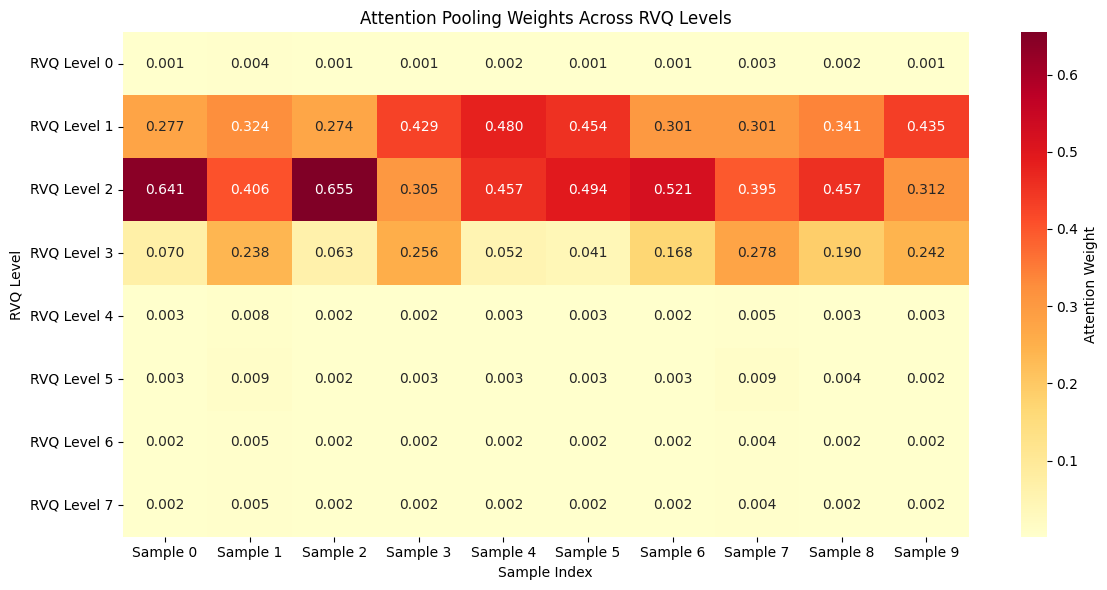


Mean attention weights across RVQ levels:
  Level 0: 0.0020
  Level 1: 0.3591
  Level 2: 0.4220
  Level 3: 0.2038
  Level 4: 0.0037
  Level 5: 0.0040
  Level 6: 0.0028
  Level 7: 0.0026


In [ ]:
import seaborn as sns

model.eval()
test_batch = next(iter(test_loader))
audio_codes_levels = [codes.to(device) for codes in test_batch['audio_codes_levels']]
padding_mask = test_batch['padding_mask'].to(device)

with torch.no_grad():
    level_outputs = []
    for level_idx in range(model.num_rvq_levels):
        audio_codes = audio_codes_levels[level_idx]
        x = model.codebook_embeddings[level_idx](audio_codes)
        x = model.positional_encodings[level_idx](x)
        x = model.transformer_encoders[level_idx](x, src_key_padding_mask=padding_mask)
        x = x.transpose(1, 2)
        x = model.temporal_pooling(x).squeeze(-1)
        level_outputs.append(x)

    batch_size = level_outputs[0].size(0)
    stacked = torch.stack(level_outputs, dim=1)
    query = model.attention_pooling.query.expand(batch_size, -1, -1)
    _, attn_weights = model.attention_pooling.multihead_attn(query, stacked, stacked)

    attn_weights = attn_weights.squeeze(1).cpu().numpy()

plt.figure(figsize=(12, 6))
sns.heatmap(
    attn_weights[:10].T,
    annot=True,
    fmt='.3f',
    cmap='YlOrRd',
    xticklabels=[f'Sample {i}' for i in range(10)],
    yticklabels=[f'RVQ Level {i}' for i in range(NUM_RVQ_LEVELS)],
    cbar_kws={'label': 'Attention Weight'}
)
plt.title('Attention Pooling Weights Across RVQ Levels')
plt.xlabel('Sample Index')
plt.ylabel('RVQ Level')
plt.tight_layout()
plt.show()

mean_attn = attn_weights.mean(axis=0)
print("\nMean attention weights across RVQ levels:")
for i, weight in enumerate(mean_attn):
    print(f"  Level {i}: {weight:.4f}")


In [ ]:
!wget https://huggingface.co/spaces/tonyassi/voice-clone/resolve/main/audio/Megan-Fox.mp3

--2025-10-11 15:57:44--  https://huggingface.co/spaces/tonyassi/voice-clone/resolve/main/audio/Megan-Fox.mp3
Resolving huggingface.co (huggingface.co)... 13.35.202.121, 13.35.202.34, 13.35.202.97, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.121|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /api/resolve-cache/spaces/tonyassi/voice-clone/9d9a216978ee1956e7f1f7f9df1a1670f3308bf8/audio%2FMegan-Fox.mp3?%2Fspaces%2Ftonyassi%2Fvoice-clone%2Fresolve%2Fmain%2Faudio%2FMegan-Fox.mp3=&etag=%22058375bdba0da3fd863b5928e506e0eadcceea76%22 [following]
--2025-10-11 15:57:44--  https://huggingface.co/api/resolve-cache/spaces/tonyassi/voice-clone/9d9a216978ee1956e7f1f7f9df1a1670f3308bf8/audio%2FMegan-Fox.mp3?%2Fspaces%2Ftonyassi%2Fvoice-clone%2Fresolve%2Fmain%2Faudio%2FMegan-Fox.mp3=&etag=%22058375bdba0da3fd863b5928e506e0eadcceea76%22
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 200 OK
Length: 3179

In [ ]:
from IPython.display import Audio

Audio("/content/Megan-Fox.mp3")


In [ ]:
import librosa
import soundfile as sf
import numpy as np

def load_audio_file(audio_path, target_sr=24000):
    try:
        audio_array, sr = sf.read(audio_path)
    except:
        audio_array, sr = librosa.load(audio_path, sr=None)

    if len(audio_array.shape) > 1:
        audio_array = audio_array.mean(axis=1)

    if sr != target_sr:
        audio_array = librosa.resample(audio_array, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    if audio_array.dtype == np.int16:
        audio_array = audio_array.astype(np.float32) / 32768.0
    elif audio_array.dtype == np.int32:
        audio_array = audio_array.astype(np.float32) / 2147483648.0

    return audio_array, sr


def predict_gender_from_file(
    audio_path,
    model,
    feature_extractor,
    mimi_model,
    device,
    num_rvq_levels,
    max_duration=5.0
):
    model.eval()
    print(f"Loading audio from: {audio_path}")
    audio_array, sr = load_audio_file(audio_path, target_sr=feature_extractor.sampling_rate)
    print(f"Audio loaded: {len(audio_array)} samples, {sr} Hz, {len(audio_array)/sr:.2f} seconds")

    max_samples = int(max_duration * sr)
    if len(audio_array) > max_samples:
        print(f"Trimming audio to {max_duration} seconds")
        audio_array = audio_array[:max_samples]

    inputs = feature_extractor(
        raw_audio=audio_array,
        sampling_rate=feature_extractor.sampling_rate,
        return_tensors="pt",
        padding=True
    )

    with torch.no_grad():
        inputs_device = inputs["input_values"].to(device)
        encoder_outputs = mimi_model.encode(inputs_device)
        audio_codes_levels = []
        for level in range(num_rvq_levels):
            level_codes = encoder_outputs.audio_codes[0, level, :].unsqueeze(0).to(device)
            audio_codes_levels.append(level_codes)

        logits = model(audio_codes_levels)
        probabilities = F.softmax(logits, dim=1)
        prediction_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, prediction_idx].item()
        prob_dict = {
            'male': probabilities[0, 0].item(),
            'female': probabilities[0, 1].item()
        }

    label_map_inv = {0: 'male', 1: 'female'}
    prediction = label_map_inv[prediction_idx]

    return prediction, confidence, prob_dict


audio_file_path = "/content/Megan-Fox.mp3"

predicted_gender, confidence, probabilities = predict_gender_from_file(
    audio_file_path,
    model,
    feature_extractor,
    mimi_model,
    device,
    NUM_RVQ_LEVELS
)

print("\n" + "="*60)
print("INFERENCE RESULTS")
print("="*60)
print(f"Audio file:       {audio_file_path}")
print(f"Predicted gender: {predicted_gender}")
print(f"Confidence:       {confidence:.4f} ({confidence*100:.2f}%)")
print(f"\nProbabilities:")
print(f"  Male:   {probabilities['male']:.4f} ({probabilities['male']*100:.2f}%)")
print(f"  Female: {probabilities['female']:.4f} ({probabilities['female']*100:.2f}%)")
print("="*60)


Loading audio from: /content/Megan-Fox.mp3
Audio loaded: 44161 samples, 24000 Hz, 1.84 seconds

INFERENCE RESULTS
Audio file:       /content/Megan-Fox.mp3
Predicted gender: female
Confidence:       0.9048 (90.48%)

Probabilities:
  Male:   0.0952 (9.52%)
  Female: 0.9048 (90.48%)


In [ ]:
!wget https://huggingface.co/spaces/tonyassi/voice-clone/resolve/main/audio/Jeff-Goldblum.mp3

--2025-10-11 16:00:56--  https://huggingface.co/spaces/tonyassi/voice-clone/resolve/main/audio/Jeff-Goldblum.mp3
Resolving huggingface.co (huggingface.co)... 13.35.202.34, 13.35.202.97, 13.35.202.40, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.34|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /api/resolve-cache/spaces/tonyassi/voice-clone/9d9a216978ee1956e7f1f7f9df1a1670f3308bf8/audio%2FJeff-Goldblum.mp3?%2Fspaces%2Ftonyassi%2Fvoice-clone%2Fresolve%2Fmain%2Faudio%2FJeff-Goldblum.mp3=&etag=%22dcdaabc0e49706cb018aaa0fc984b0fcce476dbe%22 [following]
--2025-10-11 16:00:56--  https://huggingface.co/api/resolve-cache/spaces/tonyassi/voice-clone/9d9a216978ee1956e7f1f7f9df1a1670f3308bf8/audio%2FJeff-Goldblum.mp3?%2Fspaces%2Ftonyassi%2Fvoice-clone%2Fresolve%2Fmain%2Faudio%2FJeff-Goldblum.mp3=&etag=%22dcdaabc0e49706cb018aaa0fc984b0fcce476dbe%22
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 2

In [ ]:
from IPython.display import Audio

Audio("/content/Jeff-Goldblum.mp3")


In [ ]:
audio_file_path = "/content/Jeff-Goldblum.mp3"

predicted_gender, confidence, probabilities = predict_gender_from_file(
    audio_file_path,
    model,
    feature_extractor,
    mimi_model,
    device,
    NUM_RVQ_LEVELS
)

print("\n" + "="*60)
print("INFERENCE RESULTS")
print("="*60)
print(f"Audio file:       {audio_file_path}")
print(f"Predicted gender: {predicted_gender}")
print(f"Confidence:       {confidence:.4f} ({confidence*100:.2f}%)")
print(f"\nProbabilities:")
print(f"  Male:   {probabilities['male']:.4f} ({probabilities['male']*100:.2f}%)")
print(f"  Female: {probabilities['female']:.4f} ({probabilities['female']*100:.2f}%)")
print("="*60)

Loading audio from: /content/Jeff-Goldblum.mp3
Audio loaded: 48614 samples, 24000 Hz, 2.03 seconds

INFERENCE RESULTS
Audio file:       /content/Jeff-Goldblum.mp3
Predicted gender: male
Confidence:       0.9891 (98.91%)

Probabilities:
  Male:   0.9891 (98.91%)
  Female: 0.0109 (1.09%)
